In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objs as go
import plotly
import plotly.subplots as sp
import plotly.io as pio
import os
from cloudvolume import CloudVolume as cv
from caveclient import CAVEclient
import meshparty
import navis
import pygsheets

vol =cv('graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3', agglomerate=True, use_https=True)
client = CAVEclient('zheng_ca3')

isotropy = [5,5,2]
d_from_nucleus = 20000   # [nm]


In [53]:
gc = pygsheets.authorize(service_file = "./hippca3-8126bea0d603.json")
sheet = gc.open('all_pyramidal_cells')
worksheet = sheet.worksheet('title','all_pyr_v2_remove_dupes')
pc_df = worksheet.get_as_df()

PC_nucleus_file_path = './data/pyramidal_cells_with_depth.csv'
table1 = pd.read_csv(PC_nucleus_file_path,  dtype={'x':int,'y':int,'z':int,'nuclei_id':str, 'Pyramidal':str})
PC_table = table1[table1['Pyramidal'] == 'Yes']
nuclei_coord_in_vol = PC_table[['x','y','z']].to_numpy()

latest_roots_PC = []
print('Getting latest roots for PC...')  
cell_ids_scatter = vol.scattered_points(nuclei_coord_in_vol)
for i in range(0, len(nuclei_coord_in_vol)):
    if i % 100 == 0:
        print(i)
    cell_ID = [cell_ids_scatter.get(tuple(nuclei_coord_in_vol[i,:]))]
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0]-150, nuclei_coord_in_vol[i,1], nuclei_coord_in_vol[i,2]].squeeze()])
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0], nuclei_coord_in_vol[i,1]+150, nuclei_coord_in_vol[i,2]].squeeze()])
    if cell_ID[0] == 0:
        cell_ID = np.array([vol[nuclei_coord_in_vol[i,0], nuclei_coord_in_vol[i,1]-150, nuclei_coord_in_vol[i,2]].squeeze()])
    if cell_ID[0] == 0:
        print("Failed to find neuron segment ID using nuclei center")

    else:
        if client.chunkedgraph.is_latest_roots(cell_ID[0]):
            latest_roots_PC.append(cell_ID[0])
        else:
            latest_roots_PC.append(client.chunkedgraph.suggest_latest_roots(cell_ID[0]))
latest_roots_PC_str = [str(num) for num in latest_roots_PC]


in_sheet = gc.open('CA3 proofreading')
in_worksheet = in_sheet.worksheet('title','10.inhibitory_axons')
orphan_df = in_worksheet.get_as_df(start='A7')
orphan_df = orphan_df[(orphan_df['supervoxel'] != '')]
orphan_sv = orphan_df['supervoxel']

latest_roots_orphan = []
for i in range(0, len(orphan_sv)):
    latest_roots_orphan.append(client.chunkedgraph.get_root_id(supervoxel_id=orphan_sv[i]))

/opt/anaconda3/envs/allensdk/lib/python3.10/site-packages/pygsheets/worksheet.py:1554: UserWarning: At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.
  warnings.warn('At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.')


Getting latest roots for PC...


Downloading: 100%|████████████████████████████████████████████████████████████████████| 1809/1809 [00:19<00:00, 90.69it/s]


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


In [54]:
# for all orphan axons

from scipy.spatial import KDTree
import networkx as nx

#orphan_axons = [[35502,51237,1269],[36547,46437,1448],[46313,52134,568],[29531,64069,676],[49386,56214,169]]
#latest_roots_orphan=np.hstack(latest_roots_orphan)    

path_lengths = []
for i in range(0, len(latest_roots_orphan)):
    this_path_lengths = []
    syn_on_pc = client.materialize.synapse_query(pre_ids=latest_roots_orphan[i], post_ids=latest_roots_PC, bounding_box=None, bounding_box_column='post_pt_position', 
                                        timestamp=None, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                                        split_positions=False, desired_resolution=[1000,1000,1000], materialization_version=None, 
                                        synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True)    
    syn_to_pc_freq = syn_on_pc['post_pt_root_id'].value_counts()
    target_pc_ids = syn_to_pc_freq.keys()
    
    for j in range(0, len(target_pc_ids)):
        idx = latest_roots_PC_str.index(str(target_pc_ids[j]))
        try:
            #sk = navis.read_swc('./skel/sk_nuclei_idx_' + str(idx)+'.swc',include_subdirs=False)
            sk = navis.read_swc('./skel/sk_' + str(idx)+'.swc',include_subdirs=False)
            sk_nodes = sk.nodes[['x','y','z']].to_numpy()
            this_syn = np.vstack(syn_on_pc[syn_on_pc['post_pt_root_id'] == target_pc_ids[j]]['post_pt_position'].to_numpy())
            print(i, j)
            tree = KDTree(sk_nodes)
            dist, ind_nearest = tree.query(this_syn)
            nuclei_coord_in_microns = nuclei_coord_in_vol[idx,:]*[18,18,45]/1000
            dist2, ind_root = tree.query(nuclei_coord_in_microns)
            pl = nx.single_source_dijkstra_path_length(sk.graph.to_undirected(), source=ind_root, weight='weight')
            temp = [pl.get(item) for item in ind_nearest]
            this_path_lengths.append(temp)    
        except:
            print('no skeleton file available')
            continue
    path_lengths.append(this_path_lengths)
        
    

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 37
3 38
3 39
3 40
3 41
3 42
3 43
3 44
3 45
3 46
3 47
3 48
3 49
3 50
3 51
3 52
3 53
3 54
3 55
3 56
3 57
3 58
3 59
3 60
3 61
3 62
3 63
3 64
3 65
3 66
3 67
3 68
3 69
3 70
3 71
3 72
3 73
3 74
3 75
3 76
3 77
3 78
3 79
3 80
3 81
3 82
3 83
3 84
3 85
3 86
3 87
3 88
3 89
3 90
3 91
3 92
3 93
3 94
3 95
3 96
3 97
3 98
3 99
3 100
3 101
3 102
3 103
3 104
3 105
3 106
3 107
3 108
3 109
3 110
3 111
3 112
3 113
3 114
3 115
3 116
3 117
3 118
3 119
3 120
3 121
3 122
3 123
3 124
3 125
3 126
3 127
3 128
3 129
3 130
3 131
3 132
3 133
3 134
3 135
3 136
3 137
3 138
3 139
3 140
3 141
3 142
3 143
3 144
3 145
3 146
3 147
3 148
3 149
3 150
3 151
3 152
3 153
3 154
3 155
3 156
3 157
3 158
3 159
3 160
3 161
3 162
3 163
3 164
3 165
3 166
3 167
3 168
3 169
3 170
3 171
3 172
3 173
3 174
3 175
3 176
3 177
3 178
3 179
3 180
3 181
3 182
3 183
3 184
3 185
3 186
3 187
3 188
3 189
3 190
3 191
3 192
3 193
3 194
3 195
3 196
3 197
3 198
3 199
3 200
3 201
3 202
3 203
3 204


5 409
5 410
5 411
5 412
5 413
5 414
5 415
5 416
5 417
5 418
5 419
5 420
5 421
5 422
5 423
5 424
5 425
5 426
5 427
5 428
5 429
5 430
5 431
5 432
5 433
5 434
5 435
5 436
5 437
5 438
5 439
5 440
5 441
no skeleton file available
5 443
5 444
5 445
5 446
5 447
5 448
5 449
5 450
5 451
5 452
5 453
5 454
5 455
5 456
5 457
5 458
5 459
5 460
5 461
5 462
5 463
5 464
5 465
5 466
5 467
5 468
5 469
5 470
5 471
5 472
5 473
5 474
5 475
5 476
5 477
5 478
5 479
5 480
5 481
5 482
5 483
5 484
5 485
5 486
5 487
5 488
5 489
5 490
5 491
5 492
5 493
5 494
5 495
5 496
5 497
5 498
5 499
5 500
5 501
5 502
5 503
5 504
5 505
5 506
5 507
5 508
5 509
5 510
5 511
5 512
5 513
5 514
5 515
5 516
5 517
5 518
5 519
5 520
5 521
5 522
5 523
5 524
5 525
5 526
5 527
5 528
5 529
5 530
5 531
5 532
5 533
5 534
5 535
5 536
5 537
5 538
5 539
5 540
5 541
5 542
5 543
5 544
5 545
5 546
5 547
5 548
5 549
5 550
5 551
5 552
5 553
5 554
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
6 20
6 21
6 2

9 290
9 291
9 292
9 293
9 294
9 295
9 296
9 297
9 298
9 299
9 300
9 301
9 302
9 303
9 304
9 305
9 306
9 307
9 308
9 309
9 310
9 311
9 312
9 313
9 314
9 315
9 316
9 317
9 318
9 319
9 320
9 321
9 322
9 323
9 324
9 325
9 326
9 327
9 328
9 329
9 330
9 331
9 332
9 333
9 334
9 335
9 336
9 337
9 338
9 339
9 340
9 341
9 342
9 343
9 344
9 345
9 346
9 347
9 348
9 349
9 350
9 351
9 352
9 353
9 354
9 355
9 356
9 357
9 358
9 359
9 360
9 361
9 362
9 363
9 364
9 365
9 366
9 367
9 368
9 369
9 370
9 371
9 372
9 373
9 374
9 375
9 376
9 377
9 378
9 379
9 380
9 381
9 382
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
10 16
10 17
10 18
10 19
10 20
10 21
10 22
10 23
10 24
10 25
10 26
10 27
10 28
10 29
10 30
10 31
10 32
10 33
10 34
10 35
10 36
10 37
10 38
10 39
10 40
10 41
10 42
10 43
10 44
10 45
10 46
10 47
10 48
10 49
10 50
10 51
10 52
10 53
10 54
10 55
10 56
10 57
10 58
10 59
10 60
10 61
10 62
10 63
10 64
10 65
10 66
10 67
10 68
10 69
10 70
10 71
10 72
10 73
10 74
10

12 168
12 169
12 170
12 171
12 172
12 173
12 174
12 175
12 176
12 177
12 178
12 179
12 180
12 181
12 182
12 183
12 184
12 185
12 186
12 187
12 188
12 189
12 190
12 191
12 192
12 193
12 194
12 195
12 196
12 197
12 198
12 199
12 200
12 201
12 202
12 203
12 204
12 205
12 206
12 207
12 208
12 209
12 210
12 211
12 212
12 213
12 214
12 215
12 216
12 217
12 218
12 219
12 220
12 221
no skeleton file available
12 223
12 224
12 225
12 226
12 227
12 228
12 229
12 230
12 231
12 232
12 233
12 234
12 235
12 236
12 237
12 238
12 239
12 240
12 241
12 242
12 243
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
13 11
13 12
13 13
13 14
13 15
13 16
13 17
13 18
13 19
13 20
13 21
13 22
13 23
13 24
13 25
13 26
13 27
13 28
13 29
13 30
13 31
13 32
13 33
13 34
13 35
13 36
13 37
13 38
13 39
13 40
13 41
13 42
13 43
13 44
13 45
13 46
13 47
13 48
13 49
13 50
13 51
13 52
13 53
13 54
13 55
13 56
13 57
13 58
13 59
13 60
13 61
13 62
13 63
13 64
13 65
13 66
13 67
13 68
13 69
13 70
13 71
13 72
13 73
13 74
13 75
13

16 154
16 155
16 156
16 157
16 158
16 159
16 160
16 161
16 162
16 163
16 164
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
17 11
17 12
17 13
17 14
17 15
17 16
17 17
17 18
17 19
17 20
17 21
17 22
17 23
17 24
17 25
17 26
17 27
17 28
17 29
17 30
17 31
17 32
17 33
17 34
17 35
17 36
17 37
17 38
17 39
17 40
17 41
17 42
17 43
17 44
17 45
17 46
17 47
17 48
17 49
17 50
17 51
17 52
17 53
17 54
17 55
17 56
17 57
17 58
17 59
17 60
17 61
17 62
17 63
17 64
17 65
17 66
17 67
17 68
17 69
17 70
17 71
17 72
17 73
17 74
17 75
17 76
17 77
17 78
17 79
17 80
17 81
17 82
17 83
17 84
17 85
17 86
17 87
17 88
17 89
17 90
17 91
17 92
17 93
17 94
17 95
17 96
17 97
17 98
17 99
17 100
17 101
17 102
17 103
17 104
17 105
17 106
17 107
17 108
17 109
17 110
17 111
17 112
17 113
17 114
17 115
17 116
17 117
17 118
17 119
17 120
17 121
17 122
17 123
17 124
17 125
17 126
17 127
17 128
17 129
17 130
17 131
17 132
17 133
17 134
17 135
17 136
17 137
17 138
17 139
17 140
17 141
17 142
17 143
17 144
17 145
17 146
17 1

21 171
21 172
21 173
21 174
21 175
21 176
21 177
21 178
21 179
21 180
21 181
21 182
22 0
22 1
22 2
22 3
22 4
22 5
22 6
22 7
22 8
22 9
22 10
22 11
22 12
22 13
22 14
22 15
22 16
22 17
22 18
22 19
22 20
22 21
22 22
22 23
22 24
22 25
22 26
22 27
22 28
22 29
22 30
22 31
22 32
22 33
22 34
22 35
22 36
22 37
22 38
22 39
22 40
22 41
22 42
22 43
22 44
22 45
22 46
22 47
22 48
22 49
22 50
22 51
22 52
22 53
22 54
22 55
22 56
22 57
22 58
22 59
22 60
22 61
22 62
22 63
22 64
22 65
22 66
22 67
22 68
22 69
22 70
22 71
22 72
22 73
22 74
22 75
22 76
22 77
22 78
22 79
22 80
22 81
22 82
22 83
22 84
22 85
22 86
22 87
22 88
22 89
22 90
22 91
22 92
22 93
22 94
22 95
22 96
22 97
22 98
22 99
22 100
22 101
22 102
22 103
22 104
22 105
22 106
22 107
22 108
22 109
22 110
22 111
22 112
22 113
22 114
22 115
22 116
22 117
22 118
22 119
22 120
22 121
22 122
22 123
22 124
22 125
22 126
22 127
22 128
22 129
22 130
22 131
22 132
22 133
22 134
22 135
22 136
22 137
22 138
22 139
22 140
22 141
22 142
22 143
22 144
22 145
22 1

26 146
26 147
26 148
26 149
26 150
26 151
26 152
26 153
26 154
26 155
26 156
26 157
26 158
26 159
26 160
26 161
26 162
26 163
26 164
26 165
26 166
26 167
26 168
26 169
26 170
26 171
26 172
26 173
26 174
26 175
26 176
26 177
26 178
26 179
26 180
26 181
26 182
26 183
26 184
26 185
26 186
26 187
26 188
26 189
26 190
26 191
26 192
26 193
26 194
26 195
26 196
26 197
26 198
26 199
26 200
26 201
26 202
26 203
26 204
26 205
26 206
26 207
26 208
26 209
26 210
26 211
26 212
26 213
26 214
26 215
26 216
26 217
26 218
26 219
26 220
26 221
26 222
26 223
26 224
26 225
26 226
26 227
26 228
26 229
26 230
26 231
26 232
26 233
26 234
26 235
26 236
26 237
26 238
26 239
26 240
26 241
26 242
26 243
26 244
26 245
26 246
26 247
26 248
26 249
26 250
26 251
26 252
26 253
26 254
26 255
26 256
26 257
26 258
26 259
26 260
26 261
26 262
26 263
26 264
26 265
26 266
26 267
26 268
26 269
26 270
26 271
26 272
26 273
26 274
26 275
26 276
26 277
26 278
26 279
26 280
26 281
26 282
26 283
26 284
26 285
26 286
26 287
26 288

30 126
30 127
30 128
30 129
30 130
30 131
30 132
30 133
30 134
30 135
30 136
30 137
30 138
30 139
30 140
30 141
30 142
30 143
30 144
30 145
30 146
30 147
30 148
30 149
30 150
30 151
30 152
30 153
30 154
30 155
30 156
30 157
30 158
30 159
30 160
30 161
30 162
30 163
30 164
30 165
30 166
30 167
30 168
30 169
30 170
30 171
30 172
30 173
30 174
30 175
30 176
30 177
30 178
30 179
30 180
30 181
30 182
30 183
30 184
30 185
30 186
30 187
30 188
30 189
30 190
30 191
30 192
30 193
30 194
30 195
30 196
30 197
30 198
30 199
30 200
30 201
30 202
30 203
30 204
30 205
30 206
30 207
30 208
30 209
30 210
30 211
30 212
30 213
30 214
30 215
30 216
30 217
30 218
30 219
30 220
30 221
30 222
30 223
30 224
30 225
30 226
30 227
30 228
30 229
30 230
30 231
30 232
30 233
30 234
30 235
30 236
30 237
30 238
30 239
30 240
30 241
30 242
30 243
30 244
30 245
30 246
30 247
30 248
30 249
30 250
30 251
30 252
30 253
30 254
30 255
30 256
30 257
30 258
30 259
30 260
30 261
30 262
30 263
30 264
30 265
30 266
30 267
30 268

34 194
34 195
34 196
34 197
34 198
34 199
34 200
34 201
34 202
34 203
34 204
34 205
34 206
34 207
34 208
34 209
34 210
35 0
35 1
35 2
35 3
35 4
35 5
35 6
35 7
35 8
35 9
35 10
35 11
35 12
35 13
35 14
35 15
35 16
35 17
35 18
35 19
35 20
35 21
35 22
35 23
35 24
35 25
35 26
35 27
35 28
35 29
35 30
35 31
35 32
35 33
35 34
35 35
35 36
35 37
35 38
35 39
35 40
35 41
35 42
35 43
35 44
35 45
35 46
35 47
35 48
35 49
35 50
35 51
35 52
35 53
35 54
35 55
35 56
35 57
35 58
35 59
35 60
35 61
35 62
35 63
35 64
35 65
35 66
35 67
35 68
35 69
35 70
35 71
35 72
35 73
35 74
35 75
35 76
35 77
35 78
35 79
35 80
35 81
35 82
35 83
35 84
35 85
35 86
35 87
35 88
35 89
35 90
35 91
35 92
35 93
35 94
35 95
35 96
35 97
35 98
35 99
35 100
35 101
35 102
35 103
35 104
35 105
35 106
35 107
35 108
35 109
35 110
35 111
35 112
35 113
35 114
35 115
35 116
35 117
35 118
35 119
35 120
35 121
35 122
35 123
35 124
35 125
35 126
35 127
35 128
35 129
35 130
35 131
35 132
35 133
35 134
35 135
35 136
35 137
35 138
35 139
35 140
35 1

41 103
41 104
41 105
41 106
41 107
41 108
41 109
41 110
41 111
41 112
41 113
41 114
41 115
41 116
41 117
41 118
41 119
41 120
41 121
41 122
41 123
41 124
41 125
41 126
41 127
41 128
41 129
41 130
41 131
41 132
41 133
41 134
41 135
41 136
41 137
41 138
41 139
41 140
41 141
41 142
41 143
41 144
41 145
41 146
41 147
41 148
41 149
41 150
41 151
41 152
41 153
41 154
41 155
41 156
41 157
41 158
41 159
41 160
41 161
41 162
41 163
41 164
41 165
41 166
41 167
41 168
41 169
41 170
41 171
41 172
41 173
41 174
41 175
42 0
42 1
42 2
42 3
42 4
42 5
42 6
42 7
42 8
42 9
42 10
42 11
42 12
42 13
42 14
42 15
42 16
42 17
42 18
42 19
42 20
42 21
42 22
42 23
42 24
42 25
42 26
42 27
42 28
42 29
42 30
42 31
42 32
42 33
42 34
42 35
42 36
42 37
42 38
42 39
42 40
42 41
42 42
42 43
42 44
42 45
42 46
42 47
42 48
42 49
42 50
42 51
42 52
42 53
42 54
42 55
42 56
42 57
42 58
42 59
42 60
42 61
42 62
42 63
42 64
42 65
42 66
42 67
42 68
42 69
42 70
42 71
42 72
42 73
42 74
42 75
42 76
42 77
42 78
42 79
42 80
42 81
42 82
4

48 67
48 68
48 69
48 70
48 71
48 72
48 73
no skeleton file available
48 75
48 76
48 77
48 78
48 79
48 80
48 81
48 82
48 83
48 84
48 85
48 86
48 87
48 88
48 89
48 90
48 91
48 92
48 93
48 94
48 95
48 96
48 97
48 98
48 99
48 100
48 101
48 102
48 103
48 104
48 105
48 106
48 107
48 108
48 109
48 110
48 111
48 112
48 113
48 114
48 115
48 116
48 117
48 118
48 119
48 120
48 121
48 122
48 123
48 124
48 125
48 126
48 127
48 128
48 129
48 130
48 131
48 132
48 133
48 134
48 135
48 136
48 137
48 138
48 139
48 140
48 141
48 142
48 143
48 144
48 145
48 146
48 147
48 148
48 149
48 150
48 151
48 152
48 153
48 154
48 155
48 156
48 157
48 158
48 159
48 160
49 0
49 1
49 2
49 3
49 4
49 5
49 6
49 7
49 8
49 9
49 10
49 11
49 12
49 13
49 14
49 15
49 16
49 17
49 18
49 19
49 20
49 21
49 22
49 23
49 24
49 25
49 26
49 27
49 28
49 29
49 30
49 31
49 32
49 33
49 34
49 35
49 36
49 37
49 38
49 39
49 40
49 41
49 42
49 43
49 44
49 45
49 46
49 47
49 48
49 49
49 50
49 51
49 52
49 53
49 54
49 55
49 56
49 57
49 58
50 0
50 1


55 154
55 155
55 156
55 157
55 158
55 159
55 160
55 161
55 162
55 163
55 164
55 165
55 166
55 167
56 0
56 1
56 2
56 3
56 4
56 5
56 6
56 7
56 8
56 9
56 10
56 11
56 12
56 13
56 14
56 15
56 16
56 17
56 18
56 19
56 20
56 21
56 22
56 23
56 24
56 25
56 26
56 27
56 28
56 29
56 30
56 31
56 32
56 33
56 34
56 35
56 36
56 37
56 38
56 39
56 40
56 41
56 42
56 43
56 44
56 45
56 46
56 47
56 48
56 49
56 50
56 51
56 52
56 53
56 54
56 55
56 56
56 57
56 58
56 59
56 60
56 61
56 62
56 63
56 64
56 65
56 66
56 67
56 68
56 69
56 70
56 71
56 72
56 73
56 74
56 75
56 76
56 77
56 78
56 79
56 80
56 81
56 82
56 83
56 84
56 85
56 86
56 87
56 88
56 89
56 90
56 91
56 92
56 93
56 94
56 95
56 96
56 97
56 98
56 99
56 100
56 101
56 102
56 103
56 104
56 105
56 106
56 107
56 108
56 109
56 110
56 111
56 112
56 113
56 114
56 115
56 116
56 117
56 118
56 119
56 120
56 121
56 122
56 123
56 124
56 125
56 126
56 127
56 128
56 129
56 130
56 131
56 132
56 133
56 134
56 135
56 136
56 137
56 138
56 139
56 140
56 141
56 142
56 143
56 1

65 37
65 38
65 39
65 40
65 41
65 42
65 43
65 44
65 45
65 46
65 47
65 48
65 49
65 50
65 51
65 52
65 53
65 54
65 55
65 56
65 57
65 58
65 59
65 60
65 61
65 62
65 63
65 64
65 65
65 66
65 67
65 68
65 69
65 70
65 71
65 72
65 73
65 74
65 75
65 76
65 77
65 78
65 79
65 80
65 81
65 82
65 83
65 84
65 85
65 86
65 87
65 88
65 89
65 90
65 91
65 92
65 93
65 94
65 95
65 96
65 97
65 98
65 99
65 100
65 101
65 102
65 103
65 104
65 105
65 106
65 107
65 108
65 109
65 110
65 111
65 112
65 113
65 114
65 115
65 116
65 117
65 118
65 119
65 120
65 121
65 122
65 123
65 124
65 125
65 126
65 127
65 128
65 129
65 130
65 131
65 132
65 133
65 134
65 135
65 136
65 137
65 138
65 139
65 140
65 141
65 142
65 143
65 144
65 145
65 146
65 147
65 148
65 149
65 150
65 151
65 152
65 153
65 154
65 155
65 156
65 157
65 158
65 159
65 160
65 161
65 162
65 163
65 164
65 165
65 166
65 167
65 168
65 169
65 170
65 171
65 172
65 173
65 174
65 175
65 176
65 177
66 0
66 1
66 2
66 3
66 4
66 5
66 6
66 7
66 8
66 9
66 10
66 11
66 12
66 13
66

74 79
74 80
74 81
74 82
74 83
74 84
74 85
74 86
74 87
74 88
74 89
74 90
74 91
74 92
74 93
74 94
74 95
74 96
74 97
74 98
74 99
75 0
75 1
75 2
75 3
75 4
75 5
75 6
75 7
75 8
75 9
75 10
75 11
75 12
75 13
75 14
75 15
75 16
75 17
75 18
75 19
75 20
75 21
75 22
75 23
75 24
75 25
75 26
75 27
75 28
75 29
75 30
75 31
75 32
75 33
75 34
75 35
75 36
75 37
75 38
75 39
75 40
75 41
75 42
75 43
75 44
75 45
75 46
75 47
75 48
75 49
75 50
75 51
75 52
75 53
75 54
75 55
75 56
75 57
75 58
75 59
75 60
75 61
75 62
75 63
75 64
75 65
75 66
75 67
75 68
75 69
75 70
75 71
75 72
75 73
75 74
76 0
76 1
76 2
76 3
76 4
76 5
76 6
76 7
76 8
76 9
76 10
76 11
76 12
76 13
76 14
76 15
76 16
76 17
76 18
76 19
76 20
76 21
76 22
76 23
76 24
76 25
76 26
76 27
76 28
76 29
76 30
76 31
76 32
76 33
76 34
76 35
76 36
76 37
76 38
76 39
76 40
76 41
76 42
76 43
76 44
76 45
76 46
76 47
76 48
76 49
76 50
76 51
76 52
76 53
76 54
76 55
76 56
76 57
76 58
76 59
76 60
76 61
76 62
76 63
76 64
76 65
76 66
76 67
76 68
76 69
76 70
76 71
76 72
76 73


90 0
90 1
90 2
90 3
90 4
90 5
90 6
90 7
90 8
90 9
90 10
90 11
90 12
90 13
90 14
90 15
90 16
90 17
90 18
90 19
90 20
90 21
90 22
90 23
90 24
90 25
90 26
90 27
90 28
90 29
90 30
90 31
90 32
90 33
90 34
90 35
90 36
90 37
90 38
90 39
90 40
90 41
90 42
90 43
90 44
90 45
90 46
90 47
90 48
90 49
90 50
90 51
90 52
90 53
90 54
90 55
90 56
90 57
90 58
90 59
90 60
90 61
90 62
90 63
90 64
90 65
90 66
90 67
90 68
90 69
90 70
90 71
90 72
90 73
90 74
91 0
91 1
91 2
91 3
91 4
91 5
91 6
91 7
91 8
91 9
91 10
91 11
91 12
91 13
91 14
91 15
91 16
91 17
91 18
91 19
91 20
91 21
91 22
91 23
91 24
91 25
91 26
91 27
91 28
91 29
91 30
91 31
91 32
92 0
92 1
92 2
92 3
92 4
92 5
92 6
92 7
92 8
92 9
92 10
92 11
92 12
92 13
92 14
92 15
92 16
92 17
92 18
92 19
92 20
92 21
92 22
92 23
92 24
92 25
92 26
92 27
92 28
92 29
92 30
92 31
92 32
92 33
92 34
92 35
92 36
92 37
92 38
92 39
92 40
92 41
92 42
92 43
92 44
92 45
92 46
92 47
92 48
92 49
92 50
92 51
92 52
92 53
92 54
92 55
92 56
92 57
92 58
92 59
92 60
92 61
92 62
92 6

In [65]:
from scipy.stats import gaussian_kde
       
my_bins = np.linspace(0,250,25)
mode_number = []

for i in range(0, len(latest_roots_orphan)):
    data_for_plot = np.hstack(path_lengths[i])
    kde = gaussian_kde(data_for_plot)
    x_range = np.linspace(min(data_for_plot), max(data_for_plot),1000)
    kde_values = kde(x_range)
    mode_number.append([int(x_range[np.argmax(kde_values)])])


In [66]:
in_worksheet.update_values('Y8', mode_number)


<Figure size 1000x800 with 0 Axes>

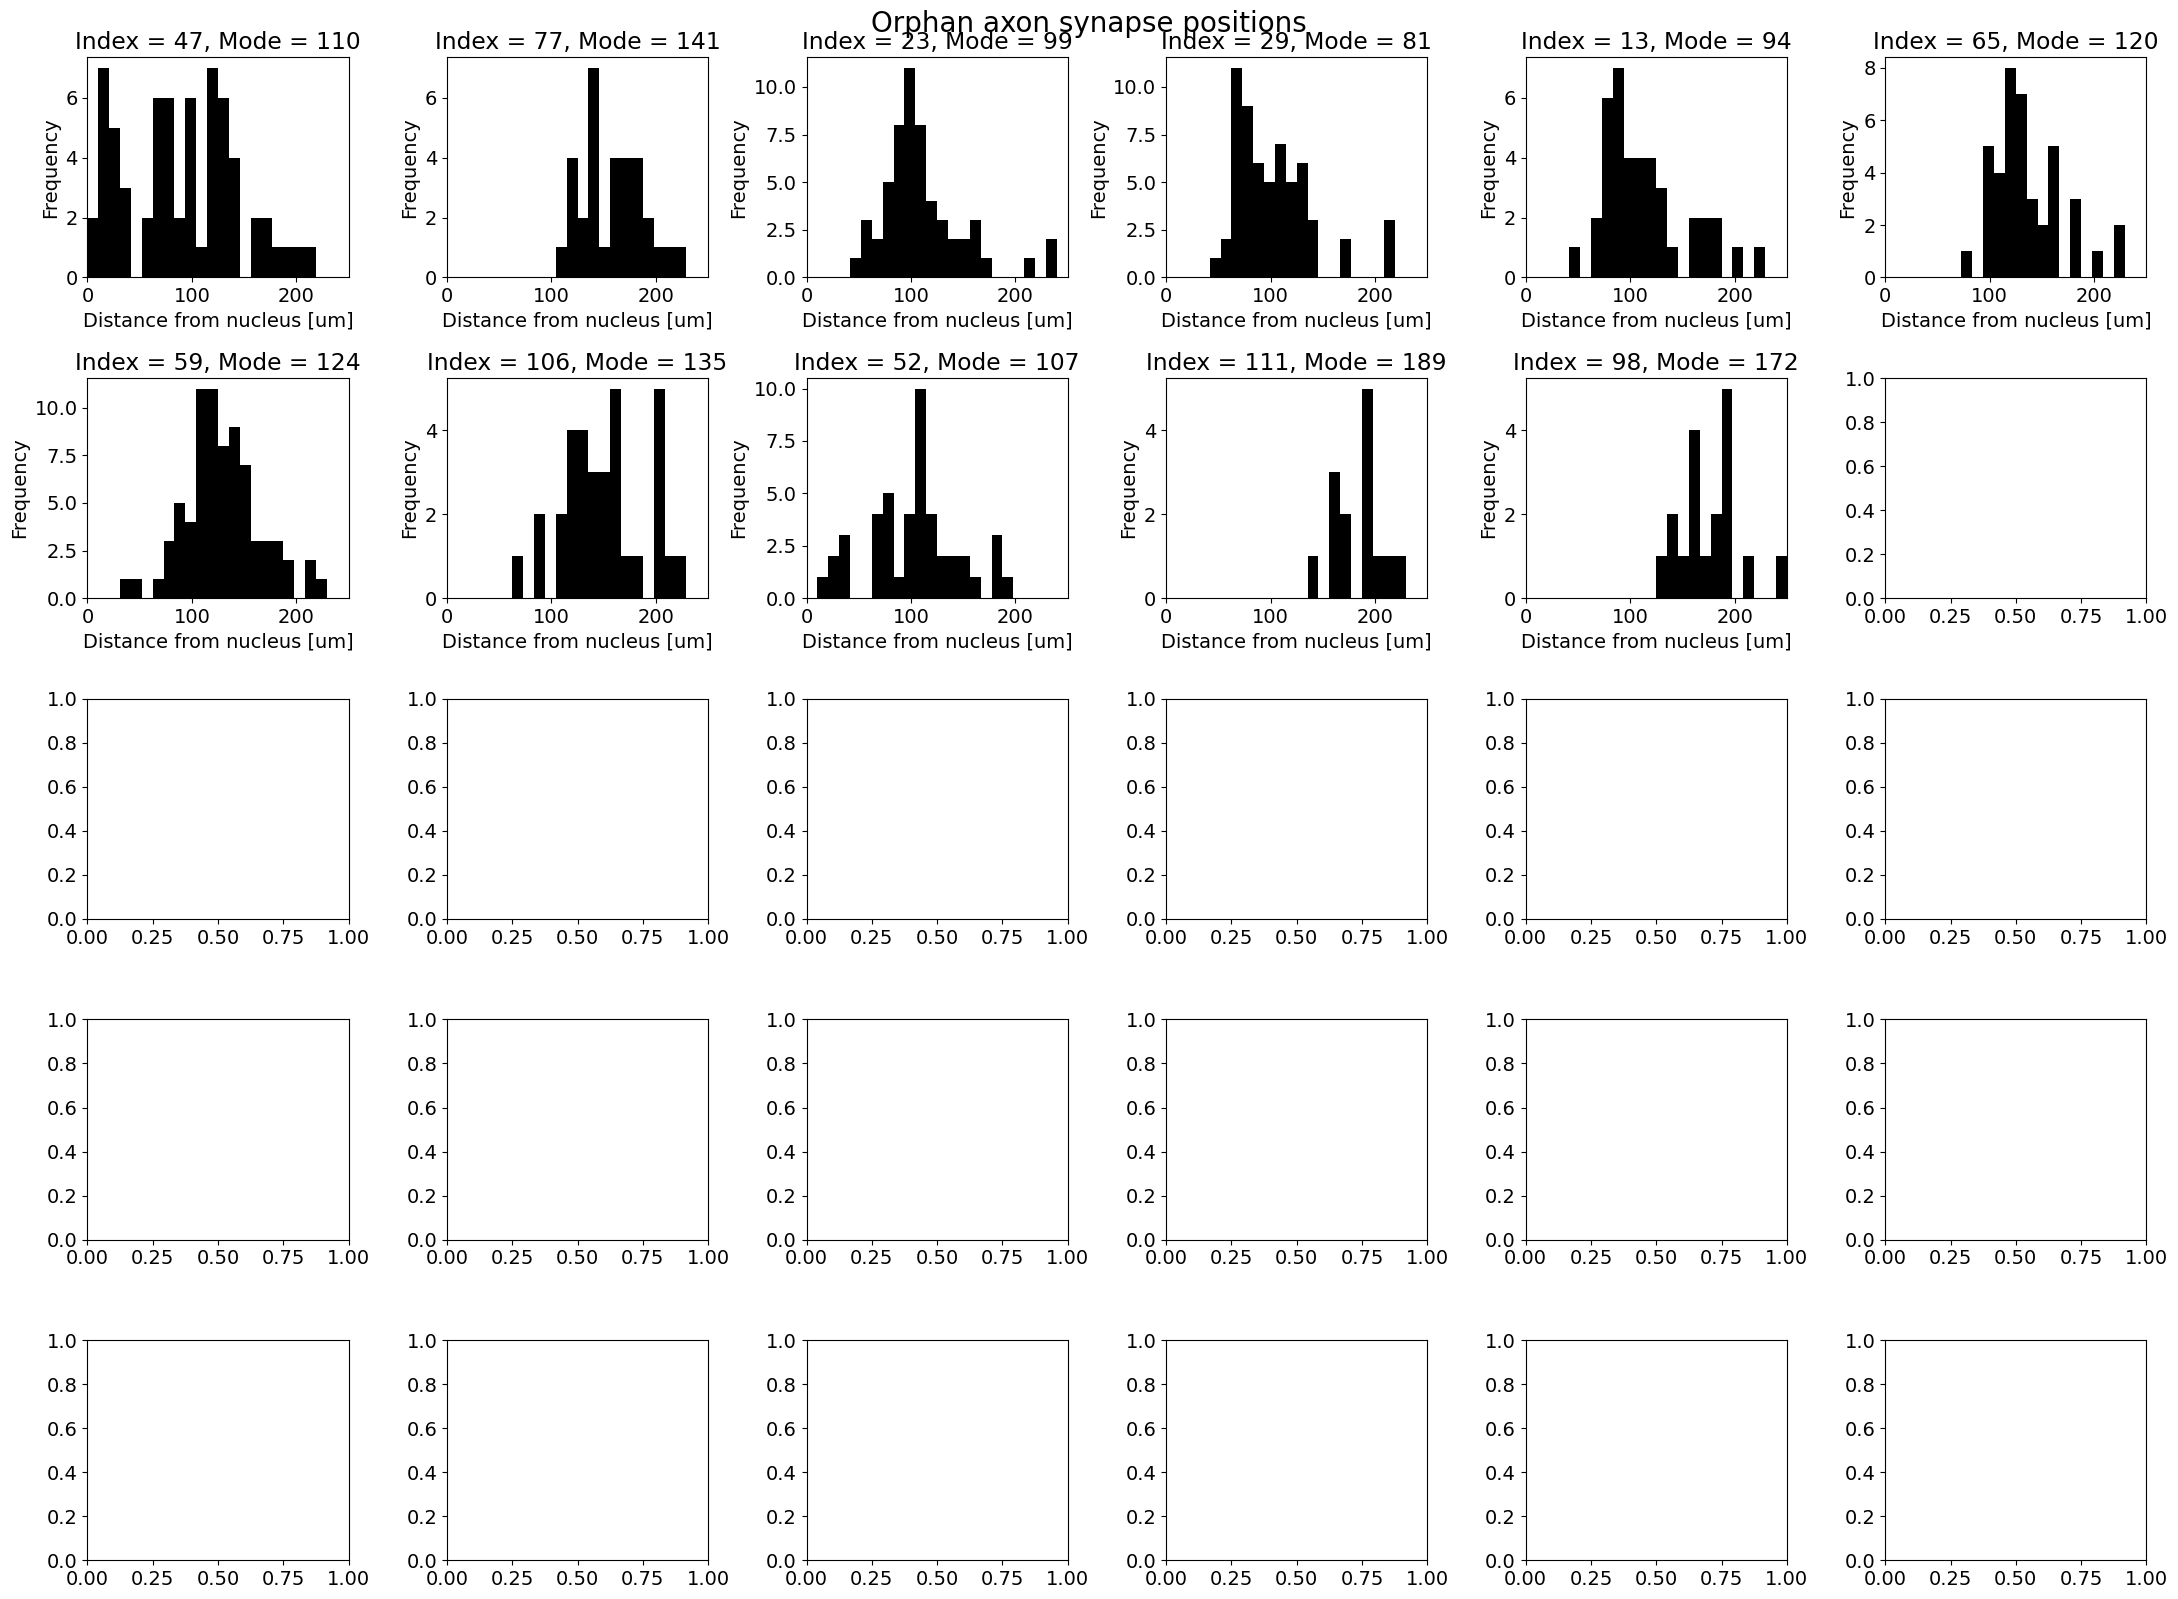

In [42]:
from scipy.stats import gaussian_kde

#index_table = orphan_table[['index','x','y','z']].dropna(how='any').to_numpy()
#axon_index = [item[0] for item in index_table]

colors = ['purple']

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':14})            
my_bins = np.linspace(0,250,25)
#plt.hist(d_from_nucleus_perisoma_collapsed, bins=my_bins, color=colors[0], alpha=1)
#plt.hist(d_from_nucleus_dend_collapsed, bins=my_bins, color=colors[1], alpha=1)
#plt.xlabel('Distance from nucleus [voxels, 90nm isotropic]')
#plt.ylabel('Frequency')
#plt.title('Perisoma-targeting (r) vs Dend-targeting (b) cells')

mode_number = []

fig, axes = plt.subplots(5,6, figsize=(22,16))
axes = axes.flatten()
for i in range(11):
    panel_idx = i+90
    data_for_plot = np.hstack(path_lengths[panel_idx])
    kde = gaussian_kde(data_for_plot)
    x_range = np.linspace(min(data_for_plot), max(data_for_plot),1000)
    kde_values = kde(x_range)
    modal_number = x_range[np.argmax(kde_values)]
    mode_number.append(modal_number)
    axes[i].hist(np.hstack(path_lengths[panel_idx]), bins=my_bins, color='black')
    axes[i].set_xlabel('Distance from nucleus [um]')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(0,250)
    axes[i].set_title('Index = ' + str(axon_index[panel_idx]) + ', Mode = ' + str(int(modal_number)))

plt.tight_layout()
plt.rcParams.update({'font.size':14})
plt.suptitle('Orphan axon synapse positions', y=1, fontsize=20)
plt.savefig("./fig/orphan_syn_skel_dist_from_target_nucleus_f4.jpg", format="jpg", dpi=300)
plt.show()


Text(0, 0.5, 'Count')

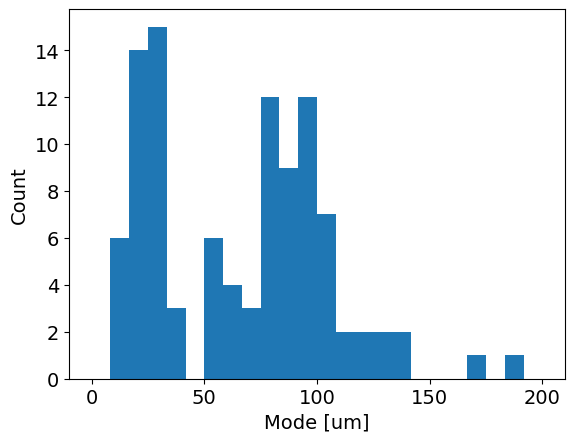

In [49]:
mode_numbers = []
my_bins2 = np.linspace(0,200,25)
for i in range(101):
    data_for_plot = np.hstack(path_lengths[i])
    kde = gaussian_kde(data_for_plot)
    x_range = np.linspace(min(data_for_plot), max(data_for_plot),1000)
    kde_values = kde(x_range)
    mode_numbers.append(x_range[np.argmax(kde_values)])
    
plt.hist(mode_numbers, bins=my_bins2)
plt.xlabel('Mode [um]')
plt.ylabel('Count')


In [33]:
# get target PC ids
# read skeleton of target PC - skeletons = navis.read_swc('/Users/cp8083/princeton/hippocampus/fmost_allen/UM1_DATA_swcFiles.zip')
# get synapses to target PC (resolution microns)
# find nearest nodes in skeleton from synapses post_pt_position
# calculate path length from root to the synapse nodes
# path = nx.shortest_path(sk.graph.to_undirected(), sk.soma[0], sk.leafs.node_id.values[i])

soma_targeting = [[35502,51237,1269],[36547,46437,1448],[46313,52134,568],[29531,64069,676],[49386,56214,169]]
dend_targeting = [[36547,46437,1448],[31439,54489,879],[54977,44835,151],[31120,53680,345],[31514,44093,845]]

latest_roots_soma_targeting = []
latest_roots_dend_targeting = []

for i in range(0, len(soma_targeting)):
    cell_id = np.array([vol[soma_targeting[i]].squeeze()])
    new_id = client.chunkedgraph.suggest_latest_roots(cell_id)
    latest_roots_soma_targeting.append(new_id)
for i in range(0, len(dend_targeting)):
    cell_id = np.array([vol[dend_targeting[i]].squeeze()])
    new_id = client.chunkedgraph.suggest_latest_roots(cell_id)
    latest_roots_dend_targeting.append(new_id)
    
latest_roots_soma_targeting=np.hstack(latest_roots_soma_targeting)    
latest_roots_dend_targeting=np.hstack(latest_roots_dend_targeting)   



In [159]:

from scipy.spatial import KDTree
import networkx as nx

path_lengths_soma = []
for i in range(0, len(soma_targeting)):
    this_axon = soma_targeting[i]
    this_path_lengths = []
    latest_roots_PC_str = [str(num) for num in latest_roots_PC]
    syn_on_soma = client.materialize.synapse_query(pre_ids=latest_roots_soma_targeting[i], post_ids=latest_roots_PC, bounding_box=None, bounding_box_column='post_pt_position', 
                                        timestamp=None, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                                        split_positions=False, desired_resolution=[1000,1000,1000], materialization_version=None, 
                                        synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True)    
    syn_to_pc_freq = syn_on_soma['post_pt_root_id'].value_counts()
    target_pc_ids = syn_to_pc_freq.keys()
    
    for j in range(0, len(target_pc_ids)):
        idx = latest_roots_PC_str.index(str(target_pc_ids[j]))
        try:
            sk = navis.read_swc('./skel/sk_nuclei_idx_' + str(idx)+'.swc',include_subdirs=False)
            sk_nodes = sk.nodes[['x','y','z']].to_numpy()
            this_syn = np.vstack(syn_on_soma[syn_on_soma['post_pt_root_id'] == target_pc_ids[j]]['post_pt_position'].to_numpy())
            print(i, j)
            tree = KDTree(sk_nodes)
            dist, ind_nearest = tree.query(this_syn)
            nuclei_coord_in_microns = nuclei_coord_in_vol[idx,:]*[18,18,45]/1000
            dist2, ind_root = tree.query(nuclei_coord_in_microns)
            pl = nx.single_source_dijkstra_path_length(sk.graph.to_undirected(), source=ind_root, weight='weight')
            temp = [pl.get(item) for item in ind_nearest]
            this_path_lengths.append(temp)    
        except:
            print('no skeleton file available')
            continue

    
    path_lengths_soma.append(this_path_lengths)
    
    
path_lengths_dend = []
for i in range(0, len(dend_targeting)):
    this_axon = dend_targeting[i]
    this_path_lengths = []
    latest_roots_PC_str = [str(num) for num in latest_roots_PC]
    
    syn_on_dend = client.materialize.synapse_query(pre_ids=latest_roots_dend_targeting[i], post_ids=latest_roots_PC, bounding_box=None, bounding_box_column='post_pt_position', 
                                        timestamp=None, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                                        split_positions=False, desired_resolution=[1000,1000,1000], materialization_version=None, 
                                        synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True)    
    syn_to_pc_freq = syn_on_dend['post_pt_root_id'].value_counts()
    target_pc_ids = syn_to_pc_freq.keys()    
    
    for j in range(0, len(target_pc_ids)):
        idx = latest_roots_PC_str.index(str(target_pc_ids[j]))
        try:
            sk = navis.read_swc('./skel/sk_nuclei_idx_' + str(idx)+'.swc',include_subdirs=False)        
            sk_nodes = sk.nodes[['x','y','z']].to_numpy()
            this_syn = np.vstack(syn_on_dend[syn_on_dend['post_pt_root_id'] == target_pc_ids[j]]['post_pt_position'].to_numpy())
            tree = KDTree(sk_nodes)
            dist, ind_nearest = tree.query(this_syn)
            nuclei_coord_in_microns = nuclei_coord_in_vol[idx,:]*[18,18,45]/1000
            dist2, ind_root = tree.query(nuclei_coord_in_microns)
            pl = nx.single_source_dijkstra_path_length(sk.graph.to_undirected(), source=ind_root, weight='weight')
            temp = [pl.get(item) for item in ind_nearest]
            this_path_lengths.append(temp)    
        except:
            print('no skeleton file available')
            continue

    path_lengths_dend.append(this_path_lengths)


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
no skeleton file available
no skeleton file available
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
no skeleton file available
0 41
0 42
0 43
no skeleton file available
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
no skeleton file available
0 54
0 55
0 56
0 57
0 58
0 59
0 60
no skeleton file available
0 62
0 63
0 64
0 65
0 66
no skeleton file available
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
no skeleton file available
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
no skeleton file available
0 133
0 134
0 135
0 136
0 137
no skeleton file available
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 14

3 359
3 360
3 361
3 362
3 363
3 364
3 365
3 366
3 367
3 368
3 369
3 370
3 371
3 372
3 373
3 374
3 375
3 376
3 377
3 378
3 379
3 380
3 381
3 382
3 383
3 384
3 385
3 386
3 387
3 388
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
no skeleton file available
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29
4 30
4 31
4 32
4 33
4 34
4 35
4 36
4 37
4 38
4 39
4 40
4 41
4 42
4 43
4 44
4 45
4 46
4 47
4 48
4 49
4 50
4 51
4 52
4 53
4 54
4 55
4 56
4 57
4 58
4 59
4 60
4 61
4 62
4 63
4 64
4 65
4 66
4 67
4 68
4 69
4 70
4 71
4 72
4 73
no skeleton file available
4 75
4 76
4 77
4 78
4 79
4 80
4 81
4 82
4 83
4 84
4 85
4 86
4 87
4 88
4 89
4 90
4 91
no skeleton file available
4 93
4 94
4 95
4 96
4 97
4 98
4 99
4 100
4 101
4 102
4 103
4 104
4 105
4 106
4 107
4 108
4 109
4 110
4 111
4 112
4 113
4 114
4 115
4 116
4 117
4 118
no skeleton file available
4 120
4 121
4 122
4 123
4 124
4 125
4 126
no skeleton file available
4 128
4 129
4 130
4 131
4 132
4 133
4 134
4 135
4 136


<Figure size 1000x800 with 0 Axes>

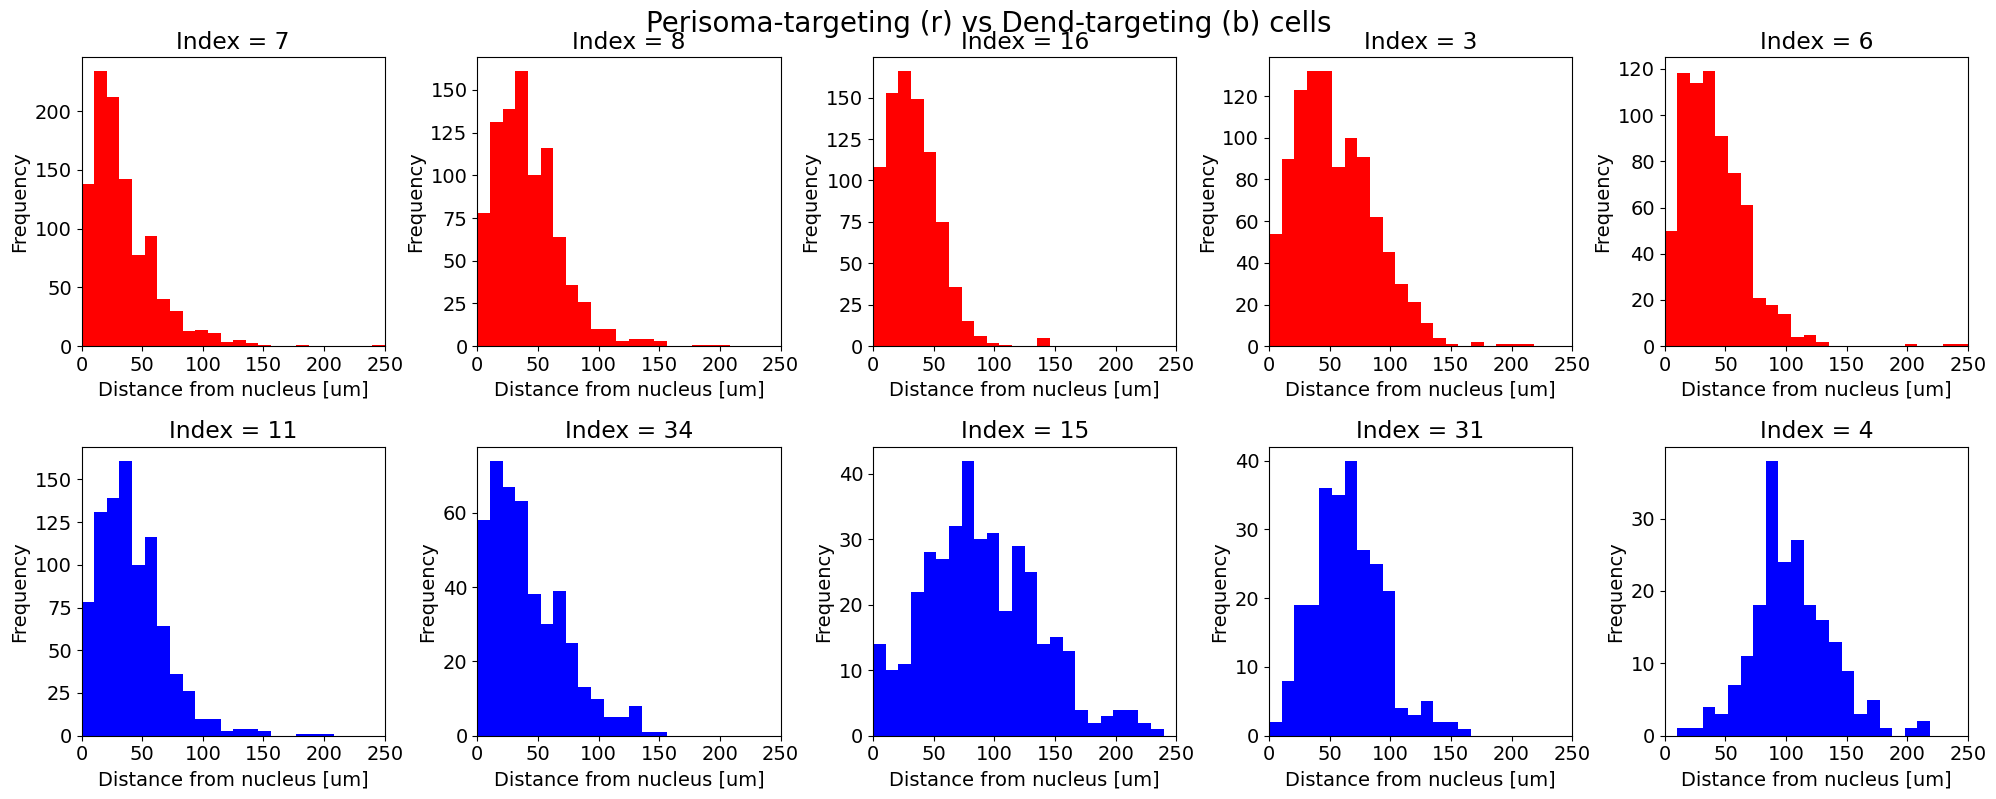

In [160]:
axon_index = ['7','8','16','3','6','11','34','15','31','4']
colors = ['red','blue','yellow','purple']
plt.figure(figsize=(10,8))
my_bins = np.linspace(0,250,25)
#plt.hist(d_from_nucleus_perisoma_collapsed, bins=my_bins, color=colors[0], alpha=1)
#plt.hist(d_from_nucleus_dend_collapsed, bins=my_bins, color=colors[1], alpha=1)
#plt.xlabel('Distance from nucleus [voxels, 90nm isotropic]')
#plt.ylabel('Frequency')
#plt.title('Perisoma-targeting (r) vs Dend-targeting (b) cells')

fig, axes = plt.subplots(2,5, figsize=(20,8))
axes = axes.flatten()
for i in range(5):
    axes[i].hist(np.hstack(path_lengths_soma[i]), bins=my_bins, color='red')
    axes[i].set_xlabel('Distance from nucleus [um]')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(0,250)
    axes[i].set_title('Index = ' + axon_index[i])
for i in range(5,10):
    axes[i].hist(np.hstack(path_lengths_dend[i-5]), bins=my_bins, color='blue')
    axes[i].set_xlabel('Distance from nucleus [um]')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(0,250)
    axes[i].set_title('Index = ' + axon_index[i])
plt.tight_layout()
plt.rcParams.update({'font.size':14})
plt.suptitle('Perisoma-targeting (r) vs Dend-targeting (b) cells', y=1, fontsize=20)
plt.savefig("./fig/syn_skel_dist_from_target_nucleus_histogram2.jpg", format="jpg", dpi=300)
plt.show()



In [141]:
print((path_lengths_soma[0]))


[[25.372209873777095, 25.131452632776767, 43.283391053525065, 42.28350686290216, 48.27627684925446, 48.27627684925446, 52.974114891225426, 52.974114891225426, 52.974114891225426, 51.27695605194827, 46.28285911711081, 26.37193018230849, 25.372209873777095, 37.2835655974542, 34.28354547004062, 36.28305475954755, 5.000320141124686, 5.900834328289225, 5.000320141124686, 5.900834328289225, 21.271073498565126, 25.131452632776767, 26.131926107013665, 5.000320141124686, 5.000320141124686, 5.900834328289225, 7.900842234685909, 26.131926107013665, 23.270878504451396, 23.270878504451396, 22.2709941912367, 22.2709941912367, 21.271073498565126, 21.271073498565126, 22.2709941912367, 21.271073498565126], [8.904655859468939, 8.68411490489994, 14.904316352498753, 14.904316352498753, 13.90427002765876, 18.905035553210336, 16.905255205340648, 17.90503567235415, 10.90447261665577, 12.904256536545464, 9.904688574498687, 32.37142270567861, 61.86763116226955, 66.86594018747581, 62.86749999487046, 67.86543649

In [145]:
print(len(np.hstack(path_lengths_soma[1])))

888


0 7
648518346436540057
[[21.345260494212123, 21.345260494212123, 20.345243787559742, 18.345277703075705, 23.345668064523935, 20.345874022648992, 22.34533911795523, 1.1930590366130738, 1.1930590366130738, 17.344902177373296, 17.34550815746173, 17.344902177373296, 21.345260494212123, 26.33350948072463, 1.1930590366130738, 18.345925843480444, 1.1930590366130738, 20.345874022648992, 22.34533911795523, 18.345277703075705, 18.345277703075705]]


/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_76522/3935624289.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(mesh.vertices[::20,0]//1000, mesh.vertices[::20,2]//1000, c=(0.7,0.7,0.7), s=2, alpha=.3)
/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_76522/3935624289.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(nuclei_coord_in_microns[0],nuclei_coord_in_microns[2], c=(

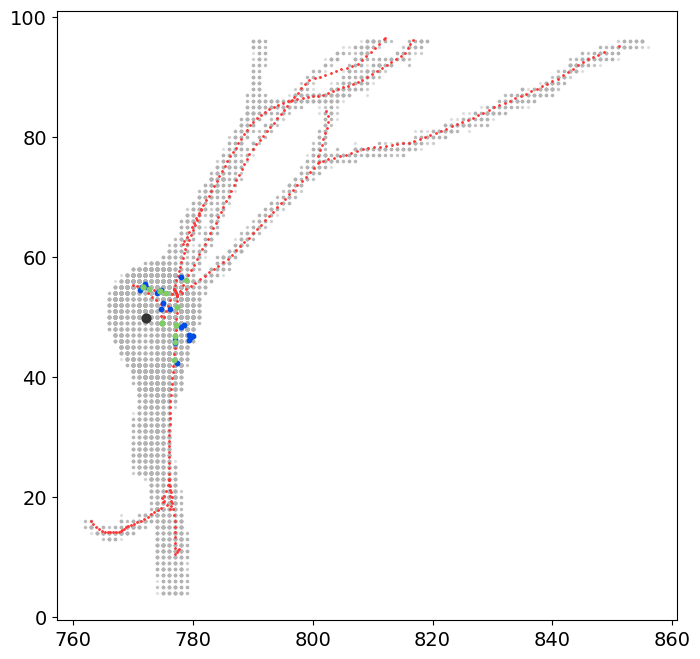

In [174]:
for i in range(0, 1):
    this_axon = soma_targeting[i]
    this_path_lengths = []
    latest_roots_PC_str = [str(num) for num in latest_roots_PC]
    syn_on_soma = client.materialize.synapse_query(pre_ids=latest_roots_soma_targeting[i], post_ids=latest_roots_PC, bounding_box=None, bounding_box_column='post_pt_position', 
                                        timestamp=None, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                                        split_positions=False, desired_resolution=[1000,1000,1000], materialization_version=None, 
                                        synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True)    
    syn_to_pc_freq = syn_on_soma['post_pt_root_id'].value_counts()
    target_pc_ids = syn_to_pc_freq.keys()
    
    for j in range(7, 8):
        idx = latest_roots_PC_str.index(str(target_pc_ids[j]))
        try:
            sk = navis.read_swc('./skel/sk_nuclei_idx_' + str(idx)+'.swc',include_subdirs=False)
        except:
            print('no skeleton file available')
            continue

        sk_nodes = sk.nodes[['x','y','z']].to_numpy()
        this_syn = np.vstack(syn_on_soma[syn_on_soma['post_pt_root_id'] == target_pc_ids[j]]['post_pt_position'].to_numpy())
        print(i, j)
        tree = KDTree(sk_nodes)
        dist, ind_nearest = tree.query(this_syn)
        nuclei_coord_in_microns = nuclei_coord_in_vol[idx,:]*[18,18,45]/1000
        dist2, ind_root = tree.query(nuclei_coord_in_microns)
        pl = nx.single_source_dijkstra_path_length(sk.graph.to_undirected(), source=ind_root, weight='weight')
        temp = [pl.get(item) for item in ind_nearest]
        this_path_lengths.append(temp) 


mesh_dir = '../mesh_data/'
mm = trimesh_io.MeshMeta(cv_path='graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3',
                        disk_cache_path=mesh_dir,
                        cache_size=20)
print(latest_roots_PC[idx])
nearest_sk_points = sk_nodes[ind_nearest]

mesh = mm.mesh(seg_id = latest_roots_PC[idx], remove_duplicate_vertices=True)
f, ax = plt.subplots(figsize=(8,8))
ax.scatter(mesh.vertices[::20,0]//1000, mesh.vertices[::20,2]//1000, c=(0.7,0.7,0.7), s=2, alpha=.3)
ax.scatter(nuclei_coord_in_microns[0],nuclei_coord_in_microns[2], c=(0.2,0.2,0.2), s=40, alpha=1)
ax.scatter(sk.nodes['x'], sk.nodes['z'], c=(1,0.2,0.2), s=1, alpha=1)
#ax.scatter([arr[0] for arr in this_syn],[arr[2] for arr in this_syn], c='b', s=10, alpha=1)
#ax.scatter([arr[0] for arr in nearest_sk_points],[arr[2] for arr in nearest_sk_points], c='g', s=10, alpha=1)
ax.scatter([arr[0] for arr in this_syn],[arr[2] for arr in this_syn], c=(0,0.3,0.9), s=10, alpha=1)
ax.scatter([arr[0] for arr in nearest_sk_points],[arr[2] for arr in nearest_sk_points], c=(0.5,0.8,0.4), s=10, alpha=1)

#ax.scatter(nuclei_coord[0]//5, nuclei_coord[2]//2, c=(0,0.6,1), s=10, alpha=1)
#ax.plot(mesh.vertices[syn_to_syn_path,0], mesh.vertices[syn_to_syn_path,2], c=(1,0.2,0.2), linewidth=4)
#ax.scatter(syn_xyz[:,0], syn_xyz[:,2], c='b', s=10)
ax.set_aspect('equal')
print(this_path_lengths)

[[728.622 927.198  31.86 ]
 [728.622 927.198  31.86 ]
 [689.917 942.04   59.328]]
